<a href="https://colab.research.google.com/github/BiancaMariaVulsan/Dog_Breed_Classification/blob/master/Breed_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class Dog Breed Classification

Dataset: https://www.kaggle.com/competitions/dog-breed-identification/data

In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
#!unzip "drive/MyDrive/Colab_Notebooks/Dog_Vision/dog-breed-identification.zip" -d "drive/MyDrive/Colab_Notebooks/Dog_Vision"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for gpu availability
print("GPU", "available (YESSSS!!!)" if tf.config.list_physical_devices() else "not available")


TF version: 2.12.0
TF Hub version: 0.13.0
GPU available (YESSSS!!!)


## Loading data

Turning images into tensors.

In [ ]:
#Checkout the labels of our data
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/Colab_Notebooks/Dog_Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: >

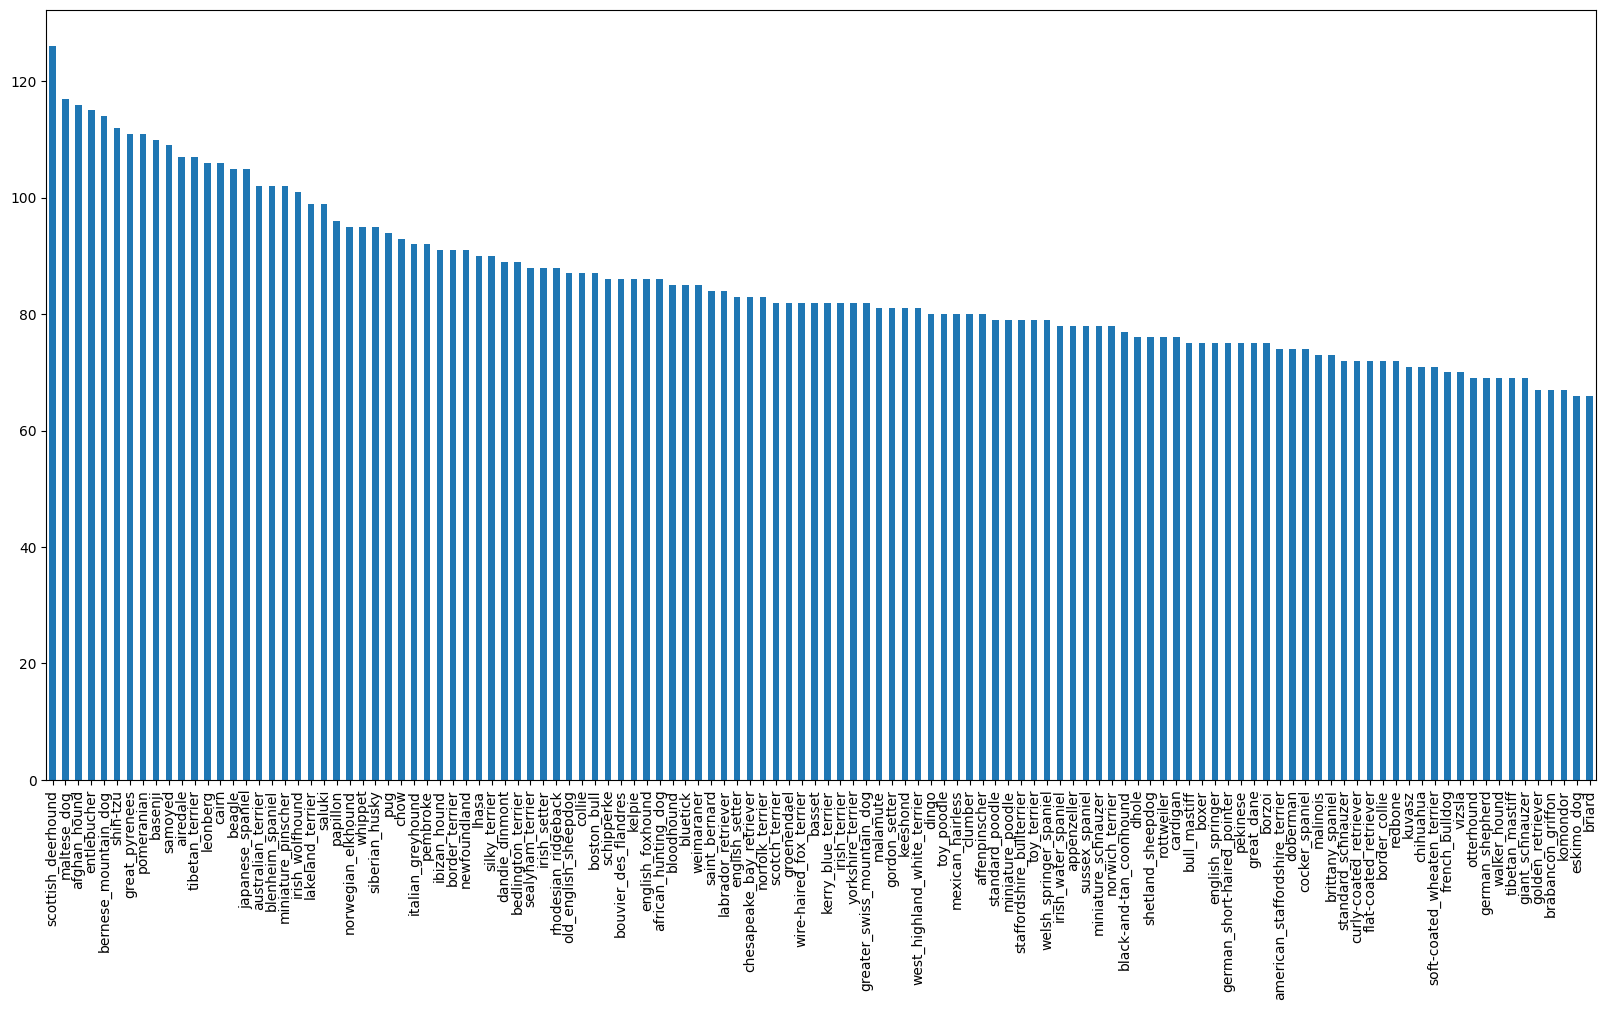

In [ ]:
#How many images are there of each bread?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
# Median number of images per class
labels_csv["breed"].value_counts().median()

82.0

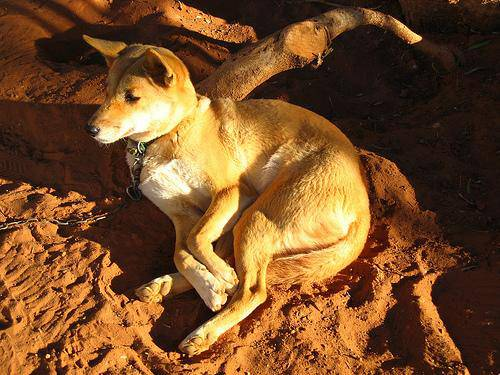

In [ ]:
# View a picture
from IPython.display import Image
Image("drive/MyDrive/Colab_Notebooks/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Getting images and their labels

In [ ]:
filenames = ["drive/MyDrive/Colab_Notebooks/Dog_Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/MyDrive/Colab_Notebooks/Dog_Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy() 
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames (check for missing data)
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


# Get the labels into a format that can be used (into numbers):

In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
unique_breeds[:10]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle'], dtype=object)

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
filenames[:10]

['drive/MyDrive/Colab_Notebooks/Dog_Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Colab_Notebooks/Dog_Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

## Creating the validation set

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

Becase we have 10222 train images, for the va;idation we start off experimenting with ~1000 images and increase if needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Processing Images (turning images into Tensors)

To preprocess the images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
Use TensorFlow to read the file and save it to a variable, image
2. Turn the image (a jpg) into Tensors
Normalize the image (convert color channel values from from 0-255 to 0-1).
3. Resize the image to be a shape of (224, 224)
4. Return the modified image

Before we do, let's see what importing an image looks like.

In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[0])
image.shape

(375, 500, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
image[:2]

array([[[109,  46,   0],
        [153,  91,  40],
        [180, 120,  68],
        ...,
        [176, 144,  71],
        [189, 157,  84],
        [214, 182, 109]],

       [[153,  92,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 135,  58],
        [171, 139,  62],
        [188, 156,  79]]], dtype=uint8)

In [ ]:
# turn image into a tensor (a tensor is able to run on a GPU, so it is faster)
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[109,  46,   0],
        [153,  91,  40],
        [180, 120,  68],
        ...,
        [176, 144,  71],
        [189, 157,  84],
        [214, 182, 109]],

       [[153,  92,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 135,  58],
        [171, 139,  62],
        [188, 156,  79]]], dtype=uint8)>

# Create the function for prerpocessing images

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning data into batches

Because if we try to to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (I found that this is the right batch size) images at a time (we can manually adjust the batch size if needed).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label).

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
process_image(X[0]), tf.constant(y[0])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.5705322 , 0.33588538, 0.15008473],
         [0.66901225, 0.4601166 , 0.26022965],
         [0.61062384, 0.43763596, 0.21601713],
         ...,
         [0.8182312 , 0.7297958 , 0.26963907],
         [0.72454786, 0.6059109 , 0.2653059 ],
         [0.7494603 , 0.6252918 , 0.32456532]],
 
        [[0.6761415 , 0.4733761 , 0.30642927],
         [0.5672121 , 0.38192675, 0.20349538],
         [0.5883547 , 0.4322571 , 0.2403155 ],
         ...,
         [0.9326942 , 0.8260503 , 0.41093278],
         [0.86072475, 0.74250627, 0.3694122 ],
         [0.76781666, 0.6461604 , 0.29291284]],
 
        [[0.46350825, 0.29595745, 0.1536156 ],
         [0.42554107, 0.27039403, 0.12009468],
         [0.7887875 , 0.6547362 , 0.49015   ],
         ...,
         [0.89372385, 0.7696401 , 0.41811958],
         [0.88609535, 0.7585918 , 0.36495727],
         [0.8243601 , 0.69494826, 0.2930575 ]],
 
        ...,
 
        [[0.7344025 , 0.4716574 

Function that turns all the data into batches:

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# Visualizing Data Batches

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

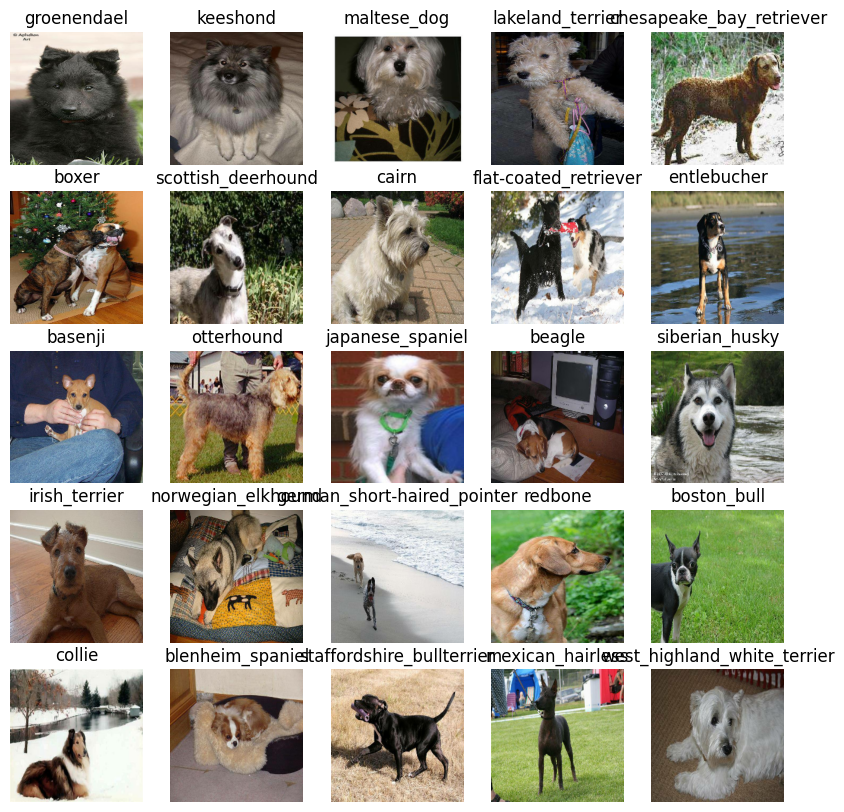

In [ ]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

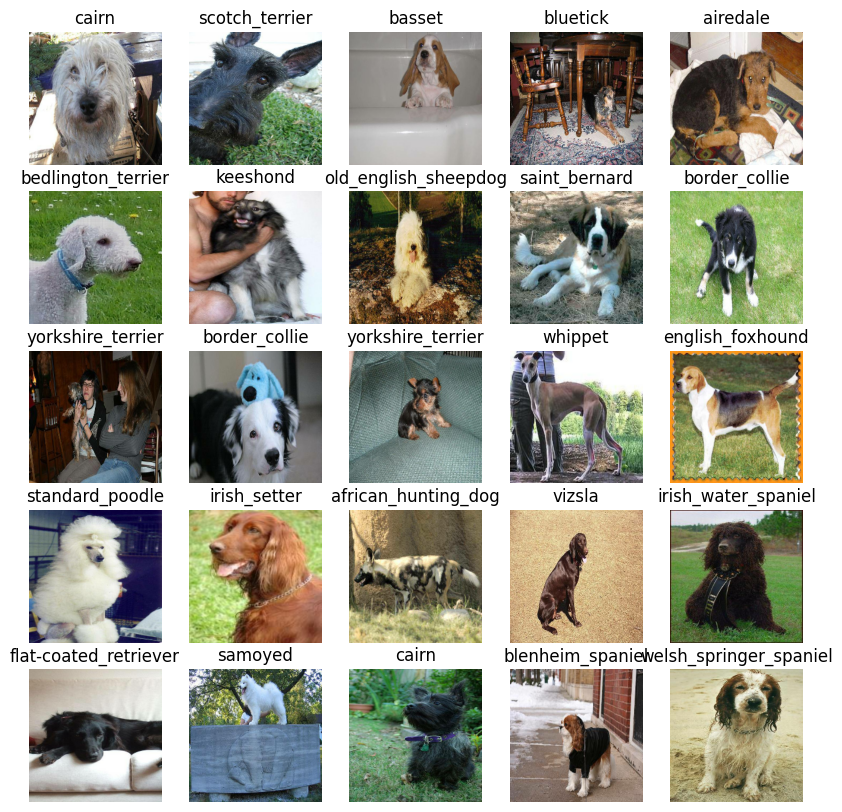

In [ ]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:

- The input shape (our images shape, in the form of Tensors) to our model.
- The output shape (image labels, in the form of Tensors) of our model.
- The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
IMG_SIZE

224

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
INPUT_SHAPE

[None, 224, 224, 3]

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

- Takes the input shape, output shape and the model we've chosen as parameters.
- Defines the layers in a Keras model in sequential fashion.
- Compiles the model (says it should be evaluated and improved).
- Builds the model (tells the model the input shape it'll be getting).
- Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

When creating the model, **softmax** is used because of the multi-class classification. For binary classification, another function like sigmoid can be used.

***The softmax function is a function that turns a vector of K real values into a vector of K real values that sum to 1.***

Loss function:** Categorical Crossentropy**, because we are dealing with multi-class classification. In case of binary classification, binary crossentropy could be used.

***Cross entropy extends the concept of information theory entropy by measuring the variation between two probability distributions for a given random variable/set of occurrences.***

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.

**Adam optimize**r is the extended version of stochastic gradient descent.

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


Here Transfer Learning has been used.

5432713 parameters bove are actually the parameters that the model have learnt while being trained on ImageNet dataset.

We need to find our 120240 additional ones.

# Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

## TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:

- Load the TensorBoard notebook extension
- Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
- Visualize our models training logs with the %tensorboard magic function (this will be done after model training).

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Colab_Notebooks/Dog_Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

## Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on a subset of data)

This first model is only going to train on 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YESSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available
